In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Layer, Dropout

print("Successfully imported libraries!")

Successfully imported libraries!


In [2]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

# Check if TensorFlow will place operations on the GPU
print("TensorFlow Version:", tf.__version__)

# Run a quick test
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print("Test computation done on GPU")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.16.1
Test computation done on GPU


2025-08-15 22:32:43.057589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-15 22:32:43.104324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-15 22:32:43.104513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-15 22:32:43.108065: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-15 22:32:43.108282: I external/local_xla/xla/stream_executor

In [3]:
# Get the absolute path of the current script's directory
current_dir = os.path.dirname(os.path.abspath("transformer0.ipynb"))

# Get the absolute path of the parent directory (project_folder)
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import from GetXY.py
from GetXY import x_train, y_train, x_val, y_val, early_stopping

# ... rest of your code
print("Successfully imported variables!")

4 + 0 + 4
2543
8.0

Expressions not in x:
-2 - -4 - 1
True
1457
1.0
15
-4.0
[-5.   1.   1.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5]
Successfully imported variables!


In [4]:
#add a cls token at the beginning of x_train and x_val
pad_value = 15
x_train = np.pad(x_train, ((0, 0), (1, 0)), 'constant', constant_values=pad_value)
x_val = np.pad(x_val, ((0, 0), (1, 0)), 'constant', constant_values=pad_value)

In [5]:
#defining the positional encoder modelled after the formula in the paper that was cited. (generated by gemini)
def posEncoding(max_seq_len, d_model):
    # Create a matrix of angles according to the formula
    angle_rads = get_angles(np.arange(max_seq_len)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    
    # Apply sine to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cosine to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # Add a batch dimension
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [6]:
#defining the point-wise FNN
#d_ff = 2048 #(original transformer size)
def point_wise_fnn(d_model, d_ff):
    return tf.keras.Sequential([
        Dense(d_ff, activation = "relu", kernel_initializer = "glorot_uniform", bias_initializer = "zeros"),
        Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
    ])

In [7]:
#scaled dot-product attention
class MH_Attention(Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        #for the split_heads function:
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #for the call function:
        #This allows the model to learn the best way to project the input embeddings. (linear projection)
        self.wq = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
        self.wk = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
        self.wv = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")

        #it's important to initialize this aswell as the ones above here, so that the model saves the previous weights and is able to learn.
        self.finalDense = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
        
    def SDP_Attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True) #calculate the dotproduct, between the query and a transposed key.
        d_k = tf.shape(k)[-1] #read the dimensionality of the key tensor (here d_model/num_heads = depth)
        d_k = tf.cast(d_k, tf.float32) #convert to float type
        scaled_qk = matmul_qk / tf.math.sqrt(d_k) #scale for purposes discussed in their paper.        

        if mask is not None:
            scaled_qk += (mask * -1e9) #masking to a big negative number
        
        softmaxed_qk = tf.nn.softmax(scaled_qk, axis = -1) #apply softmax function (axis = -1) for softmaxing all the different keys. The last entry is the number of keys (not the dimensionality of them, like it was befre.)
        output = tf.matmul(softmaxed_qk, v) #multiply the attention-weights with the values corresponding to the keys, in respect to the query.
        return output, softmaxed_qk
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) #splits up the x data which is gonna be q, k, or v, into the individual heads. effectively adding a dimension (self.num_heads), after splitting up self.d_model
        return tf.transpose(x, perm =[0,2,1,3]) #reorganizes the dimensions into the expected order (batch_size, num_heads, seq_len, depth(the new d_model "fractions"))

    def call(self, q, k ,v, mask = None):
        batch_size = tf.shape(q)[0]

        #(linear projection)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        #split them all up into the individual heads. (add a dimension basically)
        q = self.split_heads(q , batch_size)
        k = self.split_heads(k , batch_size)
        v = self.split_heads(v , batch_size)

        sdp_attention, attention_weights = self.SDP_Attention(q,k,v, mask = mask) #applies the sdp-attention to all of them. sdp_attention at the end has a shape of: (batch_size, num_heads, seq_len, depth)
        
        sdp_attention = tf.transpose(sdp_attention, perm=[0, 2, 1, 3]) #swap the 2nd and 3rd dimensions
        combined_attention = tf.reshape(sdp_attention, (batch_size, -1, self.d_model)) #combine back the two last dimnensions (num_heads and depth) into the original d_model

        output = self.finalDense(combined_attention)
        return output, attention_weights

In [8]:
class EncodingLayer(Layer):
    def __init__(self, d_model, num_heads, d_ff, rate):
        super().__init__()
        #define all the components of a Layer so the model will learn them properly here.
        self.mha = MH_Attention(d_model, num_heads)
        self.fnn = point_wise_fnn(d_model, d_ff)

        #initiate the 2 normalizations
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

        
    def call(self,x, training, mask = None):
        mha_out, attention_weights = self.mha(x,x,x,mask = mask) #for self-attention: q,k,v = x
        mha_out = self.dropout1(mha_out, training = training) #they apply a small dropout of 0.1 after every residual step in the paper.

        norm_out = self.norm1(x + mha_out) #first, add the vectors, then normalize them.

        fnn_out = self.fnn(norm_out) #2nd sub-layer with fnn
        fnn_out = self.dropout2(fnn_out, training = training) #again apply drop out

        norm2_out = self.norm2(norm_out + fnn_out) #again add and norm

        return norm2_out

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, num_layers, d_ff, rate):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers #amount of encoding layers
        self.layers = [EncodingLayer(d_model, num_heads, d_ff, rate) for i in range(num_layers)] #define multiple diffferent encoding layers here.

        self.dropout = Dropout(rate)
            
    def call(self, x, training, mask = None):
        x = self.dropout(x, training = training) #we want to drop out before the first layer
        for i in range(self.num_layers):
            x = self.layers[i](x, training = training, mask = mask)
        return x

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self, embedding_layer, d_model, max_seq_len, num_heads, num_layers, d_ff, rate):
        super().__init__()
        self.embedding = embedding_layer
        self.d_model = d_model
        self.pos_enc = posEncoding(max_seq_len, d_model)
        self.Encoder = Encoder(d_model, num_heads, num_layers, d_ff, rate)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.finalDense = Dense(1, activation = "linear", kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
        
    def call(self, x, training, mask = None):
        seq_len = tf.shape(x)[1]
        x = tf.expand_dims(x, axis=-1) #add a dimension to x
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #scale with √d_model
        x += self.pos_enc[:, :seq_len, :]
        
        out_Encoder = self.Encoder(x, training = training, mask = mask)

        output = out_Encoder[:,0,:] #pooling: to the first token.
        output = self.dropout(output, training = training) #another dropout

        final = self.finalDense(output) #now we can reduce back to a single neuron. This is the opposite of what we did in the embedding layer.

        return final
        

In [11]:
# Define a custom learning rate schedule class with warmup and cosine decay
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    A custom learning rate schedule that implements a linear warmup
    followed by a cosine decay.
    """
    def __init__(self, peak_lr, warmup_steps, decay_steps, alpha=0.0, name=None):
        super().__init__()
        self.peak_lr = peak_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmupCosineDecay"):
            # Ensure step is a float for calculations
            step = tf.cast(step, tf.float32)
            
            # --- 1. Warmup Phase ---
            # Linearly increase the learning rate from 0 to peak_lr
            warmup_lr = self.peak_lr * (step / self.warmup_steps)

            # --- 2. Cosine Decay Phase ---
            # Define the cosine decay schedule
            cosine_decay_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=self.peak_lr,
                decay_steps=self.decay_steps,
                alpha=self.alpha
            )
            # Calculate the learning rate for the decay phase.
            # Note: The 'step' for the cosine part must be relative to its start.
            decay_lr = cosine_decay_schedule(step - self.warmup_steps)

            # --- 3. Choose the correct phase ---
            # Use tf.where to select the learning rate based on the current step
            learning_rate = tf.where(
                step < self.warmup_steps,
                warmup_lr,
                decay_lr
            )
            return learning_rate

    def get_config(self):
        return {
            "peak_lr": self.peak_lr,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "alpha": self.alpha,
            "name": self.name
        }




In [12]:
import keras_tuner
from tensorflow.keras import backend as K
def build_model(hp):
    K.clear_session()
    # A smaller configuration to reduce overfitting
    # Ensure compatibility
    num_heads = hp.Choice('num_heads', [2, 4, 8])  # Powers of 2 work well
    d_model = hp.Choice('d_model', [32, 64, 128])   # Also powers of 2
    # This guarantees d_model % num_heads == 0
    num_layers = hp.Int('num_layers', 2, 6)
    d_ff = hp.Choice('d_ff', [64, 128, 256, 512])   # Multiples that work well
    if hp.Boolean("dropout"):
        dropout_rate = 0.2 
    else: 
        dropout_rate = 0
    peak_lr = hp.Float("peak learning rate", min_value = 1e-7, max_value = 1e-2, sampling="log")

    embedding_layer = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
    batch_size = 32
    num_epochs = 25
    max_seq_len = 16
    warmup_epochs = 3
    

    
    transformer_model = Transformer(
        embedding_layer = embedding_layer, 
        d_model = d_model,
        max_seq_len = max_seq_len,
        num_heads = num_heads,
        num_layers = num_layers,
        d_ff = d_ff,
        rate = dropout_rate
    )


        # Calculate steps based on your data
    # IMPORTANT: Use the actual length of your training data for this calculation
    steps_per_epoch = len(x_train) // batch_size
    warmup_steps = warmup_epochs * steps_per_epoch
    decay_steps = (num_epochs - warmup_epochs) * steps_per_epoch
    
    # Create an instance of our new scheduler
    lr_schedule = WarmupCosineDecay(
        peak_lr=peak_lr,
        warmup_steps=warmup_steps,
        decay_steps=decay_steps,
        alpha=0.1 # This means the LR will decay to 10% of peak_lr
    )

    transformer_model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay = 4e-3,
            beta_1=0.85,  
            beta_2=0.999,  # Primary recommendation: lower this
            clipnorm=1.0
        ),
        loss='mse'
    )
    return transformer_model

build_model(keras_tuner.HyperParameters())

<Transformer name=transformer, built=False>

In [13]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    overwrite=False
)

Reloading Tuner from ./untitled_project/tuner0.json


In [14]:
num_epochs = 25
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

tuner.search(train_dataset, epochs = num_epochs, validation_data = (val_dataset), verbose = 0, callbacks = [early_stopping])

In [15]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 23 summary
Hyperparameters:
num_heads: 8
d_model: 32
num_layers: 3
d_ff: 128
dropout: False
peak learning rate: 0.0014188984633416947
Score: 0.13932304084300995

Trial 04 summary
Hyperparameters:
num_heads: 2
d_model: 64
num_layers: 4
d_ff: 512
dropout: False
peak learning rate: 0.00023727638415800082
Score: 0.5695855617523193

Trial 19 summary
Hyperparameters:
num_heads: 2
d_model: 64
num_layers: 4
d_ff: 512
dropout: False
peak learning rate: 0.00017753963838400855
Score: 1.641616940498352

Trial 42 summary
Hyperparameters:
num_heads: 4
d_model: 128
num_layers: 3
d_ff: 512
dropout: False
peak learning rate: 0.0004034381760009418
Score: 6.7436699867248535

Trial 20 summary
Hyperparameters:
num_heads: 2
d_model: 64
num_layers: 4
d_ff: 512
dropout: False
peak learning rate: 0.0002221139550977517
Score: 7.766565322875977

Trial 06 summary
Hyperparameters:
num_heads: 2
d_

In [16]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

In [17]:
def build_best_model(hp, num_epochs):
    # A smaller configuration to reduce overfitting
    # Ensure compatibility
    num_heads = hp.Choice('num_heads', [2, 4, 8])  # Powers of 2 work well
    d_model = hp.Choice('d_model', [32, 64, 128])   # Also powers of 2
    # This guarantees d_model % num_heads == 0
    num_layers = hp.Int('num_layers', 2, 6)
    d_ff = hp.Choice('d_ff', [64, 128, 256, 512])   # Multiples that work well
    if hp.Boolean("dropout"):
        dropout_rate = 0.2 
    else: 
        dropout_rate = 0
    peak_lr = hp.Float("peak learning rate", min_value = 1e-7, max_value = 1e-2, sampling="log")

    embedding_layer = Dense(d_model, kernel_initializer = "glorot_uniform", bias_initializer = "zeros")
    batch_size = 32
    num_epochs = num_epochs
    max_seq_len = 16
    warmup_epochs = np.floor(num_epochs/10) + 1
    

    
    transformer_model = Transformer(
        embedding_layer = embedding_layer, 
        d_model = d_model,
        max_seq_len = max_seq_len,
        num_heads = num_heads,
        num_layers = num_layers,
        d_ff = d_ff,
        rate = dropout_rate
    )


        # Calculate steps based on your data
    # IMPORTANT: Use the actual length of your training data for this calculation
    steps_per_epoch = len(x_train) // batch_size
    warmup_steps = warmup_epochs * steps_per_epoch
    decay_steps = (num_epochs - warmup_epochs) * steps_per_epoch
    
    # Create an instance of our new scheduler
    lr_schedule = WarmupCosineDecay(
        peak_lr=peak_lr,
        warmup_steps=warmup_steps,
        decay_steps=decay_steps,
        alpha=0.1 # This means the LR will decay to 10% of peak_lr
    )

    transformer_model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay = 4e-3,
            beta_1=0.85,  
            beta_2=0.999,  # Primary recommendation: lower this
            clipnorm=1.0
        ),
        loss='mse'
    )
    return transformer_model
num_epochs_best_model = 200
best_model = build_best_model(best_hps, num_epochs_best_model)

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


I0000 00:00:1755289984.195224   19637 service.cc:145] XLA service 0xfffe6c002cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755289984.195314   19637 service.cc:153]   StreamExecutor device (0): Orin, Compute Capability 8.7
2025-08-15 22:33:04.954647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-15 22:33:07.941520: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90300


 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 27.9247

I0000 00:00:1755289998.891784   19637 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 338ms/step - loss: 25.9114 - val_loss: 24.9496
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 23.6377 - val_loss: 22.2951
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.1356 - val_loss: 19.1666
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.2383 - val_loss: 16.2498
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4174 - val_loss: 15.5344
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15.3729 - val_loss: 14.2005
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.2148 - val_loss: 13.7088
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 14.5101 - val_loss: 11.8499
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13.2370 - val_loss: 11.0068
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 13.3209 - val_loss: 12.3039
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 11.8602 - val_loss: 7.8798
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1

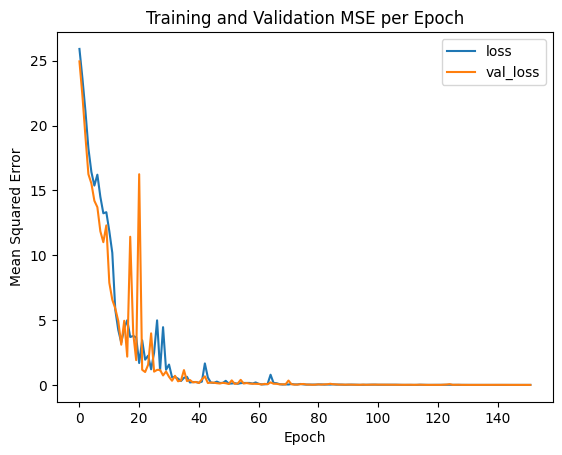

In [18]:
history = best_model.fit(
    train_dataset, # Pass the TensorFlow Dataset
    validation_data=val_dataset, # Pass the TensorFlow Dataset
    epochs=num_epochs_best_model,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation MSE per Epoch")
plt.show()

In [20]:
best_model.summary()

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 16, 32)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Encoder)             │ ?                      │        38,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,628 (447.77 KB)

 Trainable params: 38,209 (149.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,419 (298.52 KB)

In [19]:
# 1. Take one batch from the dataset to inspect it or use it for prediction.
first_batch = val_dataset.take(1)

# To print the contents of that first batch, you can iterate over it.
# (Note: .take(1) creates a new dataset with only one element, so this loop will run once)
print("Contents of the first batch:")
for batch in first_batch:
    # A batch is typically a tuple of (inputs, labels)
    inputs, labels = batch
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
print(inputs[0])
# 2. Run prediction on that single batch.
# The model's predict method can directly accept the dataset object created by .take(1).
print("\nRunning prediction on the first batch...")
predictions = best_model.predict(first_batch)
print("Predictions shape:", predictions.shape)
print(predictions[0])
print("--------------")
print(predictions)

Contents of the first batch:
Inputs shape: (32, 16)
Labels shape: (32,)
tf.Tensor(
[15.   4.   0.  -5.   0.  -5.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5], shape=(16,), dtype=float32)

Running prediction on the first batch...


2025-08-15 22:36:01.223455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (32, 1)
[13.288919]
--------------
[[ 1.3288919e+01]
 [-1.0249513e+00]
 [-2.9264622e+00]
 [-6.0107427e+00]
 [-9.8061329e-01]
 [-1.9711741e+00]
 [ 2.0516894e+00]
 [ 7.8633094e+00]
 [-9.5711529e-01]
 [ 1.0088371e+00]
 [-4.9608655e+00]
 [ 8.9442253e+00]
 [-4.9349351e+00]
 [ 1.0160669e+00]
 [-2.4901513e-02]
 [ 9.9882132e-01]
 [-2.9563727e+00]
 [ 3.0083988e+00]
 [-3.8919444e+00]
 [-9.0002508e+00]
 [-3.9580483e+00]
 [ 2.9846687e+00]
 [ 1.9960011e+00]
 [-1.1012344e+01]
 [-2.0112092e+00]
 [ 9.0181761e+00]
 [-4.9540725e+00]
 [-7.6944865e-03]
 [-2.9935086e+00]
 [-4.9706135e+00]
 [ 3.0246150e+00]
 [-6.9407458e+00]]
